In [1]:
import pandas as pd
import lightgbm as ltb
import numpy as np
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, roc_auc_score

from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5



In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

In [3]:
dir_path = 'C:/Users/Edward/Documents/Appleolga/Final_pro/model2/'
# dir_path = 'C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/'

In [4]:
# # # WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# # data_train.to_parquet((dir_path + 'train/data_train.parquet.gzip'),compression='gzip')
# # data_test.to_parquet((dir_path + 'test/data_test.parquet.gzip'),compression='gzip')

# # # READING INITIAL MERGED TRAIN AND TEST DATA FROM PARQUET
# data_train = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip')
# data_test = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip')

# # WRITING TRAIN AND TEST DATA WITH VARIANCE, QUANTILES AND SLOPE TO PARQUET

# data_train.to_parquet((dir_path + 'train/data_train_with_var.parquet.gzip'),compression='gzip')
# data_test.to_parquet((dir_path + 'test/data_test_with_var.parquet.gzip'),compression='gzip')

# data_train.to_parquet((dir_path + 'train/data_train_with_var_slope_sts.parquet.gzip'),compression='gzip')
# data_test.to_parquet((dir_path + 'test/data_test_with_var_slope_stat.parquet.gzip'),compression='gzip')


# # READING TRAIN AND TEST DATA WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

# data_train = pd.read_parquet(dir_path + 'train/data_train_with_var.parquet.gzip')
# data_test = pd.read_parquet(dir_path + 'test/data_test_with_var.parquet.gzip')

data_train = pd.read_parquet(dir_path + 'train/data_train_with_var_slope_sts.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test_with_var_slope_stat.parquet.gzip')

In [ ]:
#READING INITIAL TRAIN DATA
data_traff_train = pd.read_sas(dir_path +'train/hash_school_dpi_model_traff.sas7bdat')
data_train = pd.read_sas(dir_path + 'train/hash_school_dpi_model_fe.sas7bdat')

#READING INITIAL TEST DATA
data_traff_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_traff_test.sas7bdat')
data_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_fe_test.sas7bdat')
data_test2 = pd.read_sas(dir_path + 'test/hash_school_dpi_model_test.sas7bdat')

### 1. DATA PREPROCESSING

#### 1.1 Combining data sources and data cleaning

In [ ]:
#COMPLETE DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

print(data_train.shape)
print(data_traff_train.shape)
data_traff_train = data_traff_train.drop_duplicates()
data_train = data_train.drop_duplicates()
print(data_train.shape)
print(data_traff_train.shape)

data_train = data_train.merge(data_traff_train, on = 'abon_id')
del data_traff_train

print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)
data_test = data_test.drop_duplicates()
data_test2 = data_test2.drop_duplicates()
data_traff_test = data_traff_test.drop_duplicates()
print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)

data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
del data_test2
del data_traff_test

data_train = data_train.astype('float32')
data_test = data_test.astype('float32')

In [5]:
#PARTIAL DUPLICATES CLEANING

duplicates = list(data_train['abon_id'].value_counts().where(lambda x: x > 1).dropna().index)
data_train_duplicates = data_train.loc[data_train['abon_id'].isin(duplicates), :]
data_train_duplicates_f = data_train_duplicates[data_train_duplicates.duplicated(subset='abon_id', 
                                                                                 keep='first')].set_index('abon_id')
data_train_duplicates_l = data_train_duplicates[data_train_duplicates.duplicated(subset='abon_id', 
                                                                                 keep='last')].set_index('abon_id')
print(data_train_duplicates_f.compare(data_train_duplicates_l, align_axis = 1))

print(data_train.shape)
data_train = data_train.drop(set(data_train_duplicates.index))
print(data_train.shape)

del duplicates, data_train_duplicates, data_train_duplicates_f,data_train_duplicates_l

          bs_delte_ppd_change_tp       
                            self  other
abon_id                                
1471973.0                  0.000  0.008
1735334.0                  0.027  0.125
1735340.0                  0.027  0.125
1735408.0                  0.000  0.008
1735443.0                  0.000  0.008
1735501.0                  0.027  0.125
1735518.0                  0.027  0.125
1735531.0                  0.027  0.125
1735610.0                  0.000  0.008
1735706.0                  0.027  0.125
1735731.0                  0.027  0.125
1735821.0                  0.027  0.125
1736250.0                  0.027  0.125
1736251.0                  0.027  0.125
1756637.0                  0.000  0.008
1756697.0                  0.125  0.027
1757327.0                  0.000  0.008
1762305.0                  0.000  0.008
1762348.0                  0.027  0.125
1762371.0                  0.008  0.000
1762394.0                  0.008  0.000
1762408.0                  0.008  0.000


In [6]:
duplicates = list(data_test['abon_id'].value_counts().where(lambda x: x > 1).dropna().index)
data_test_duplicates = data_test.loc[data_test['abon_id'].isin(duplicates), :]
data_test_duplicates_f = data_test_duplicates[data_test_duplicates.duplicated(subset='abon_id',
                                                                              keep='first')].set_index('abon_id')
data_test_duplicates_l = data_test_duplicates[data_test_duplicates.duplicated(subset='abon_id',
                                                                              keep='last')].set_index('abon_id')
print(data_test_duplicates_f.compare(data_test_duplicates_l, align_axis = 1))

print(data_test.shape)
data_test = data_test.drop(set(data_test_duplicates.index))
print(data_test.shape)

del duplicates, data_test_duplicates, data_test_duplicates_f,data_test_duplicates_l

          bs_delte_ppd_change_tp       
                            self  other
abon_id                                
1735181.0                  0.027  0.125
1735206.0                  0.000  0.008
1735228.0                  0.000  0.008
1735237.0                  0.000  0.008
1735256.0                  0.027  0.125
1735316.0                  0.027  0.125
1735517.0                  0.027  0.125
1735560.0                  0.027  0.125
1735685.0                  0.027  0.125
1735701.0                  0.000  0.008
1735837.0                  0.027  0.125
1735847.0                  0.027  0.125
1735860.0                  0.027  0.125
1736228.0                  0.000  0.008
1748322.0                  0.027  0.125
1756719.0                  0.125  0.027
1762270.0                  0.027  0.125
1762306.0                  0.000  0.008
1762483.0                  0.027  0.125
1762510.0                  0.000  0.008
1767512.0                  0.027  0.125
1767638.0                  0.027  0.125


In [16]:
data_train.describe().style.format('{:.2f}')

In [17]:
data_train.isna().sum()

abon_id                                  0
Balance_uah                            704
TM_ID                                  704
lt                                    1817
CALCULATION_METHOD_ID                  704
device_days_usage                    20095
device_brand_samsung                 20095
device_brand_nokia                   20095
device_brand_lenovo                  20095
device_brand_apple                   20095
device_brand_huawei                  20095
device_brand_lg                      20095
device_brand_xiaomi                  20095
device_brand_meizu                   20095
device_brand_prestigio               20095
device_brand_sony                    20095
device_brand_nan                     20095
device_brand_other                   20095
device_android_version              177792
device_ios_version                  223789
device_has_gprs                      20095
device_has_wifi                      20095
device_has_lte                       20095
device_widt

In [18]:
data_test.isna().sum()

abon_id                                  0
Balance_uah                            812
TM_ID                                  812
lt                                    1866
CALCULATION_METHOD_ID                  812
device_days_usage                    13570
device_brand_samsung                 13570
device_brand_nokia                   13570
device_brand_lenovo                  13570
device_brand_apple                   13570
device_brand_huawei                  13570
device_brand_lg                      13570
device_brand_xiaomi                  13570
device_brand_meizu                   13570
device_brand_prestigio               13570
device_brand_sony                    13570
device_brand_nan                     13570
device_brand_other                   13570
device_android_version              171170
device_ios_version                  217376
device_has_gprs                      13570
device_has_wifi                      13570
device_has_lte                       13570
device_widt

#### 1.2 Checking for traffic features outliers

In [8]:
#CHECKING TRAFFIC VARIANCE

traffic_cols = ['traff_m5', 'traff_m4', 'traff_m3','traff_m2','traff_m1']

traff_var = pd.DataFrame(data = data_train[traffic_cols].var(), columns = ['traff_var'])
traff_var.style.format("{:.10}")

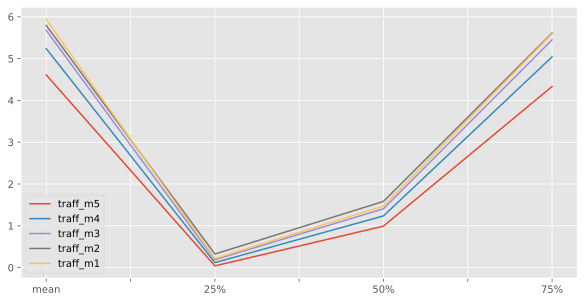

In [11]:
data_train[traffic_cols].describe().loc[['mean','25%', '50%', '75%']].plot()

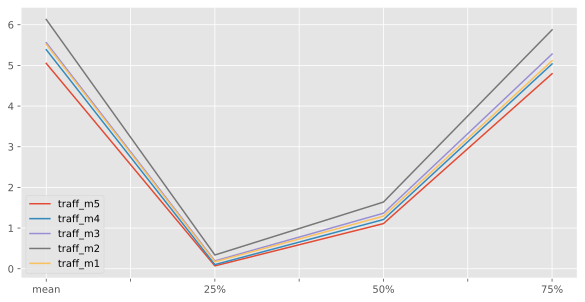

In [12]:
data_test[traffic_cols].describe().loc[['mean','25%', '50%', '75%']].plot()

### 2. Defining base model scores

In [22]:
X_train_full = data_train.drop('target', axis = 1).fillna(0)
y_train_full = data_train['target']

X_test_test_full = data_test.drop('target', axis = 1).fillna(0)
y_test_test_full = data_test['target']

In [23]:
slr = LinearRegression(normalize=True)

slr.fit(X_train_full, y_train_full)

y_train_pred = slr.predict(X_train_full)
y_test_test_pred = slr.predict(X_test_test_full)

print()
print('Train set results')
print()
print('RMSE train: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test_test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



Train set results

RMSE train: 8.362953, test: 2464850905.507687
R^2 train: 0.503634, test: -44874093341517240.000000


In [25]:
lgbm_r = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


lgbm_r.fit(X_train_full,y_train_full)
y_train_pred = lgbm_r.predict(X_train_full)
y_test_test_pred = lgbm_r.predict(X_test_test_full)

print('RMSE train: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



RMSE train: 7.554150, test_test: 8.651652
R^2 train: 0.595001, test_test:0.447143


### 3. Data Exploration

In [26]:
#FUNCTION TO RETURN A MASK FOR OUTLIERS IN A DATAFRAME

def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [27]:
#FUNCTION TO FIND CATEGORICAL COLUMNS

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list


In [29]:
#SEPARATING CATEGORICAL AND NUMERICAL COLUMNS 

cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

33
883
100
200
300
400
500
600
700
800


In [30]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES IN A DF

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [31]:
# CREATING AN INFORMATIONAL AGGREGATED DATAFRAME ON NUMERICAL FEATURES

data_train_num = data_train[num_col_list]
data_train_num_outliers_mask = mark_outliers(data_train_num)
data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
del data_train_num_outliers_mask


In [48]:
# CALCULATING FEATURES PAIRWISE CORRELATION
data_train_num_corr = data_train_num.corr()
# ADDING TARGET CORR TO THE INFO DF
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)

In [33]:
# FUNCTION TO HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [34]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.2%}",
                                                        'target': "{:.2f}"})
data_train_num_info_style

In [49]:
data_train_num_info = data_train_num_info.assign(nan_plus_univ = 
                                                 data_train_num_info['%nans'] + data_train_num_info['%of_fr_univalue'])

cols_to_drop = list(data_train_num_info[data_train_num_info['nan_plus_univ'] == 1].col)

data_train_num_info = data_train_num_info[~data_train_num_info['col'].isin(cols_to_drop)]

cols_to_drop = list(data_train_num_info[(data_train_num_info['nan_plus_univ'] > 0.99)&\
                                        (data_train_num_info['%nans'] > 0.9)].col)

data_train_num_info = data_train_num_info[~data_train_num_info['col'].isin(cols_to_drop)]

data_train_num_info_style = data_train_num_info.sort_values(by = 'nan_plus_univ', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.2%}",
                                                        'target': "{:.5f}"})
data_train_num_info_style

In [46]:
cols_to_drop = list(data_train_num_info[(data_train_num_info['nan_plus_univ'] > 0.99)&\
                                        (data_train_num_info['%nans'] > 0.9)].col)

In [47]:
cols_to_drop

['cnt_unq_category_avto',
 'cnt_bank_sms_category_tascombank',
 'AMA',
 'cnt_unq_category_taxi',
 'cnt_sms_category_taxi',
 'cnt_bank_sms_category_pravexbank',
 'SMS',
 'cnt_bank_sms_category_megabank',
 'cnt_bank_sms_category_abank',
 'cnt_unq_category_ticket',
 'cnt_bank_sms_category_ideabank',
 'cnt_bank_sms_category_mtbbank',
 'cnt_sms_category_ticket',
 'cnt_bank_sms_category_creditdnep',
 'cnt_bank_sms_category_kredobank',
 'Cars',
 'Shops',
 'cnt_bank_sms_category_forwardban',
 'cnt_bank_sms_category_sberbank',
 'cnt_unq_category_fest',
 'cnt_bank_sms_category_vostokbank',
 'cnt_bank_sms_category_agricoleba',
 'cnt_bank_sms_category_ukreximban',
 'cnt_bank_sms_category_cominbank',
 'cnt_bank_sms_category_accordbank',
 'cnt_sms_category_fest',
 'Fax',
 'cnt_bank_sms_category_pivdennyib',
 'cnt_bank_sms_category_globusbank',
 'cnt_bank_sms_category_bisbank',
 'tsoa_mail_cnt',
 'cnt_bank_sms_category_unexbank',
 'cnt_sms_category_collect',
 'cnt_bank_sms_category_radabank']

In [42]:
data_train_num_info[data_train_num_info['col'] != 'target']['target'].abs().describe()

count    859.000000
mean       0.074042
std        0.087953
min        0.000046
25%        0.010617
50%        0.051130
75%        0.102746
max        0.667549
Name: target, dtype: float64

In [ ]:
# # CALCULATION OF TRAFFIC VARIANCE AND TRAFFIC COLS LIN.REGR. SLOPE FOR EACH OBSERVATION

data_train = data_train.assign(var = data_train[traffic_cols].apply(lambda x: x.var(), axis=1))
data_train = data_train.assign(var_quant = pd.qcut(data_train['var'], 10,labels = False))

data_test = data_test.assign(var = data_test[traffic_cols].apply(lambda x: x.var(), axis=1))
data_test = data_test.assign(var_quant = pd.qcut(data_test['var'], 10,labels = False))

enum = np.arange(1, len(traffic_cols)+1, 1)

data_train = data_train.assign(slope_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_test = data_test.assign(slope_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

# data_train = data_train.assign(interc_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

# data_test = data_test.assign(interc_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

In [ ]:
data_train['slope_traff'].plot.hist(bins = 400,
                                    xlim = (-10,10),
                                    xticks = range(-10,10, 1),
                                    figsize = (9,3))


In [10]:
from scipy import stats

data_train = data_train.assign(z_score_slope = scipy.stats.zscore(data_train['slope_traff']))
                                                                
data_train = data_train.assign(big_slope = data_train['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 0.5) else 0))

data_test = data_test.assign(z_score_slope = scipy.stats.zscore(data_test['slope_traff']))
                                                                
data_test = data_test.assign(big_slope = data_test['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 0.5) else 0))

In [ ]:
data_train[data_train['big_slope'] == 1].shape

In [12]:
X_train_full = data_train[data_train['big_slope'] == 0].drop('target', axis = 1)

y_train_full = data_train[data_train['big_slope'] == 0]['target']

X_test_full = data_test[data_test['big_slope'] == 0].drop('target', axis = 1)

y_test_full = data_test[data_test['big_slope'] == 0]['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))

RMSE train: 4.484354, test: 5.611657
R^2 train: 0.595647, test: 0.428484


In [ ]:
X_train_full = data_train[data_train['big_slope'] == 1].drop('target', axis = 1)

y_train_full = data_train[data_train['big_slope'] == 1]['target']

X_test_full = data_test[data_test['big_slope'] == 1].drop('target', axis = 1)

y_test_full = data_test[data_test['big_slope'] == 1]['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))

In [13]:
X_train_full = data_train.drop(traffic_cols + ['target', 'var', 'var_quant', 'slope_traff', 'z_score_slope', 'big_slope'], 
                               axis = 1)

y_train_full = data_train['big_slope']


model = ltb.LGBMClassifier(objective ='binary',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_full, y_train_pred)

0.8048735067702564

In [14]:
big_slope_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
big_slope_features = big_slope_features[big_slope_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)

big_slope_features = big_slope_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = big_slope_features['importance'].cumsum())
big_slope_features['cum_sum']  = big_slope_features['cum_sum']/big_slope_features['importance'].sum()

print(big_slope_features.shape)
big_slope_features.style.format({'cum_sum': "{:.2%}"})




(513, 2)


In [15]:
data_descr = pd.read_csv((dir_path + 'data_descr.csv'), names=['feature', 'descr'])

big_slope_features = pd.merge(big_slope_features, data_descr, how='left', left_index=True, right_on='feature')

big_slope_features.loc[big_slope_features['descr'].isna(), 
                        'descr'] = big_slope_features.loc[big_slope_features['descr'].isna(), 'feature']

big_slope_features = big_slope_features.assign(feature_clear = big_slope_features['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

big_slope_features['feature_clear'] = big_slope_features.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))


In [16]:
slope_cols_to_use = list(big_slope_features.groupby('feature_clear')['feature'].max('importance').values)

print(len(slope_cols_to_use))
# sorted(slope_cols_to_use)

182


In [ ]:
big_slope_features.sort_values(by='importance')

In [17]:
X_train_full = data_train[slope_cols_to_use]

y_train_full = data_train['big_slope']


model = ltb.LGBMClassifier(objective ='binary',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_full, y_train_pred)

0.8003802705179861

In [18]:
big_slope_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
big_slope_features = big_slope_features[big_slope_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)

In [19]:
print(big_slope_features.shape)
big_slope_features = big_slope_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = big_slope_features['importance'].cumsum())
big_slope_features['cum_sum']  = big_slope_features['cum_sum']/big_slope_features['importance'].sum()
big_slope_features.style.format({'cum_sum': "{:.2%}"})

(171, 1)


In [20]:
X_train_full = data_train.drop(traffic_cols + ['target', 'var', 'var_quant', 'slope_traff', 'z_score_slope', 'big_slope'], 
                               axis = 1)

y_train_full = data_train['var_quant']


model = ltb.LGBMClassifier(objective ='multiclass',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)



In [21]:
from sklearn.metrics import roc_auc_score
enc = OneHotEncoder()
roc_auc_score(enc.fit_transform(y_train_full.values.reshape(-1, 1)).toarray(), 
              enc.fit_transform(y_train_pred.reshape(-1, 1)).toarray(), 
              multi_class = 'ovo')

0.7745626611029411

In [22]:
var_quant_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
var_quant_features = var_quant_features[var_quant_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)


print(var_quant_features.shape)

var_quant_features = var_quant_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = var_quant_features['importance'].cumsum())
var_quant_features['cum_sum']  = var_quant_features['cum_sum']/var_quant_features['importance'].sum()
var_quant_features.style.format({'cum_sum': "{:.2%}"})

(829, 1)


In [23]:
var_quant_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
var_quant_features = var_quant_features[var_quant_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)


var_quant_features = pd.merge(var_quant_features, data_descr, how='left', left_index=True, right_on='feature')

var_quant_features.loc[var_quant_features['descr'].isna(), 
                        'descr'] = var_quant_features.loc[var_quant_features['descr'].isna(), 'feature']

var_quant_features = var_quant_features.assign(feature_clear = var_quant_features['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

var_quant_features['feature_clear'] = var_quant_features.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

var_quant_cols_to_use = list(var_quant_features.groupby('feature_clear')['feature'].max('importance').values)


In [24]:
X_train_full = data_train[var_quant_cols_to_use]

y_train_full = data_train['var_quant']


model = ltb.LGBMClassifier(objective ='multiclass',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)

# from sklearn.metrics import roc_auc_score
enc = OneHotEncoder()
roc_auc_score(enc.fit_transform(y_train_full.values.reshape(-1, 1)).toarray(), 
              enc.fit_transform(y_train_pred.reshape(-1, 1)).toarray(), 
              multi_class = 'ovo')

0.755066075443757

In [25]:
var_quant_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
var_quant_features = var_quant_features[var_quant_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)
print(var_quant_features.shape)

var_quant_features = var_quant_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = var_quant_features['importance'].cumsum())
var_quant_features['cum_sum']  = var_quant_features['cum_sum']/var_quant_features['importance'].sum()
var_quant_features.style.format({'cum_sum': "{:.2%}"})

(273, 1)


In [ ]:
data_train.groupby(by=['big_slope', 'var_quant'])['abon_id'].count()

In [26]:
data_train.columns

Index(['abon_id', 'Balance_uah', 'TM_ID', 'lt', 'CALCULATION_METHOD_ID',
       'device_days_usage', 'device_brand_samsung', 'device_brand_nokia',
       'device_brand_lenovo', 'device_brand_apple', 'device_brand_huawei',
       'device_brand_lg', 'device_brand_xiaomi', 'device_brand_meizu',
       'device_brand_prestigio', 'device_brand_sony', 'device_brand_nan',
       'device_brand_other', 'device_android_version', 'device_ios_version',
       'device_has_gprs', 'device_has_wifi', 'device_has_lte',
       'device_width_mm', 'device_height_mm', 'device_type_modem',
       'device_type_module', 'device_type_phone', 'device_type_smartphone',
       'device_type_tablet', 'device_type_nan', 'device_type_rus_other',
       'device_sim_count', 'device_price', 'loc_cnt_events',
       'loc_is_obl_center', 'loc_lat', 'loc_lon', 'loc_market_share',
       'bs_of_succ_but_drop_m1', 'bs_of_succ_m1',
       'bs_of_unsucc_attemp_equip_m1', 'bs_of_unsucc_low_balance_m1',
       'bs_of_attemps_all_

In [27]:
data_train = data_train.assign(big_var = data_train.apply(lambda x: 0 if (x['var_quant'] < 8) else 1, axis =1))

In [28]:
X_train_full = data_train[var_quant_cols_to_use]

y_train_full = data_train['big_var']


model = ltb.LGBMClassifier(objective ='binary',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)

# from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_full, y_train_pred)

0.8837720423979892

In [29]:
big_var_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
big_var_features = big_var_features[big_var_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)
print(big_var_features.shape)

big_var_features = big_var_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = big_var_features['importance'].cumsum())
big_var_features['cum_sum']  = big_var_features['cum_sum']/big_var_features['importance'].sum()
big_var_features.style.format({'cum_sum': "{:.2%}"})

(222, 1)


In [148]:
big_slope_features.columns  = ['importance_bs', 'cum_sum_bs']
var_quant_features.columns = ['importance_vq', 'cum_sum_vq']
big_var_features.columns = ['importance_bv', 'cum_sum_bv']

total_features = big_slope_features.merge(var_quant_features,
                                          how = 'inner',
                                          left_index = True,
                                          right_index = True).merge(big_var_features,
                                                                   how = 'inner',
                                                                   left_index = True,
                                                                   right_index = True)
big_var_slope_features = list(total_features.index)

In [147]:
print(total_features.shape)
total_features.sort_values(by=['importance_bv', 'importance_bs'], ascending = False).\
    style.format({'cum_sum_bs': "{:.2%}", 'cum_sum_bv': "{:.2%}",'cum_sum_vq': "{:.2%}"})

(155, 6)


In [38]:
symlog = data_train['non_accum_internet_vol_td_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_train = data_train.assign(non_accum_internet_vol_td_mnt3_log = symlog)

symlog = data_test['non_accum_internet_vol_td_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_test = data_test.assign(non_accum_internet_vol_td_mnt3_log = symlog)

data_train = data_train.assign(non_accum_internet_vol_td_mnt3_log_bins = pd.cut(data_train['non_accum_internet_vol_td_mnt3_log'], 
                                                                                bins=range(-19, 19)))

data_test = data_test.assign(non_accum_internet_vol_td_mnt3_log_bins = pd.cut(data_test['non_accum_internet_vol_td_mnt3_log'], 
                                                                                bins=range(-19, 19)))

del symlog

In [78]:
 def ratio_diagram(df, values_col, index_col, columns_cols, comparison_names, agg_func = 'count') :
        
    pivot_df = pd.pivot_table(df, 
                              values=values_col,
                              index=index_col,
                              columns=columns_cols, 
                              aggfunc=agg_func)
    
    pivot_df.columns = comparison_names
    pivot_df = pivot_df.assign(ratio = pivot_df[comparison_names[1]]/pivot_df[comparison_names[0]])


    pivot_df.sort_values(by = 'ratio', ascending = False)

    ax1 = pivot_df.loc[:, comparison_names].plot(kind = 'bar',
                                                 figsize = (10,5),
                                                 rot = 90,
                                                 sharex = True)


    ax1 = pivot_df['ratio'].plot(secondary_y=True,
                                 colormap = 'ocean',
                                 rot = 90,
                                 legend = True,
                                 sharex = True);
    
    plt.show()
    
    return pivot_df
    
    

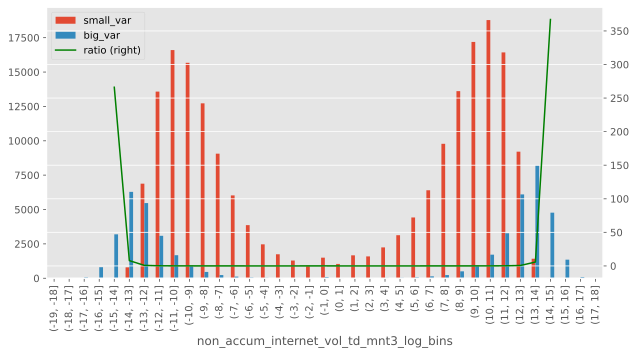

In [79]:
# temp = data_train.iloc[0:1000, :]
ratio_df = ratio_diagram(data_train, ['abon_id'], ['non_accum_internet_vol_td_mnt3_log_bins'], ['big_var'], ['small_var', 'big_var'])

In [150]:
sorted(big_var_slope_features)

['BS_OVERBUNDLE_MB_CNT_M2',
 'BS_OVERBUNDLE_MB_CNT_M3',
 'BS_OVERBUNDLE_MB_SUM_M3',
 'Balance_uah',
 'DNZ_DAYS_from_last_year1',
 'DNZ_MAX_days_closed_loan_year1',
 'DNZ_MEAN_days_closed_loan_year1',
 'DNZ_STD_days_closed_loan_year5',
 'GBA_remain_days',
 'Good_deed',
 'Internet',
 'MV_AP_total',
 'MV_ARPU',
 'MV_ARPU_2G_d_Traf',
 'MV_ARPU_Cont_out_s_Traf',
 'MV_ARPU_innet_out_v_Traf',
 'MV_DOU_Neg_Bal',
 'MV_DOU_OT',
 'MV_Migr_To',
 'MV_SERV_Y_WO_AF',
 'MV_Traf_2G_d_Mb',
 'MV_Traf_3G_d_Mb',
 'MV_Traf_4G_d_Mb',
 'MV_Traf_ACCA_out_v_Min',
 'MV_Traf_Cont_inc_s_Cnt',
 'MV_Traf_Cont_out_s_Cnt',
 'MV_Traf_Cont_out_v_Min',
 'MV_Traf_R_inc_v_Min',
 'MV_Traf_innet_out_s_Cnt',
 'MV_Traf_innet_out_v_Min',
 'MV_Traf_omo_out_v_Min',
 'MV_Traf_pstn_inc_v_Min',
 'MV_Traf_pstn_out_v_Min',
 'MV_ap_4G_d',
 'MV_ap_innet_out_v',
 'MV_ap_mn_out_v',
 'MV_ap_omo_out_v',
 'MV_ap_pstn_out_v',
 'MV_ap_s',
 'MV_dou',
 'MV_dou_2G_d',
 'MV_dou_3G_d',
 'MV_dou_4G_d',
 'MV_dou_Roam_d',
 'MV_dou_data',
 'MV_dou_inne

In [136]:
bins = data_train.non_accum_internet_vol_td_mnt3_log_bins.cat.categories[data_train.non_accum_internet_vol_td_mnt3_log_bins.cat.categories.isin(\
                                    data_train.non_accum_internet_vol_td_mnt3_log_bins.cat.categories[0:5])]

non_accum_big = data_train.loc[data_train['non_accum_internet_vol_td_mnt3_log_bins'].isin(bins)]
non_accum_big = non_accum_big.drop(['non_accum_internet_vol_td_mnt3_log_bins','dpi_download_log_bins'],
                                   axis = 1).fillna(0)
non_accum_big.isna().sum()

abon_id                               0
Balance_uah                           0
TM_ID                                 0
lt                                    0
CALCULATION_METHOD_ID                 0
device_days_usage                     0
device_brand_samsung                  0
device_brand_nokia                    0
device_brand_lenovo                   0
device_brand_apple                    0
device_brand_huawei                   0
device_brand_lg                       0
device_brand_xiaomi                   0
device_brand_meizu                    0
device_brand_prestigio                0
device_brand_sony                     0
device_brand_nan                      0
device_brand_other                    0
device_android_version                0
device_ios_version                    0
device_has_gprs                       0
device_has_wifi                       0
device_has_lte                        0
device_width_mm                       0
device_height_mm                      0


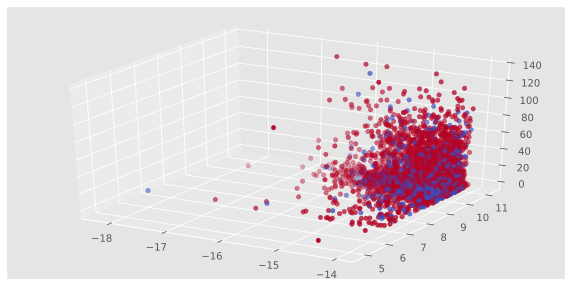

In [145]:
labels = non_accum_big['big_slope']

fig = plt.figure()
    
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(non_accum_big['non_accum_internet_vol_td_mnt3_log'],
           non_accum_big['dpi_download_log'], 
           non_accum_big['target'], 
           zdir='z', s=20, c = labels, cmap='coolwarm', depthshade=True)

plt.show()

In [69]:
symlog = data_train['dpi_download'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_train = data_train.assign(dpi_download_log = symlog)

symlog = data_test['dpi_download'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_test = data_test.assign(dpi_download_log = symlog)

data_train = data_train.assign(dpi_download_log_bins = pd.cut(data_train['dpi_download_log'], 
                                                                                bins=range(-19, 19)))

data_test = data_test.assign(dpi_download_log_bins = pd.cut(data_test['dpi_download_log'], 
                                                                                bins=range(-19, 19)))

del symlog

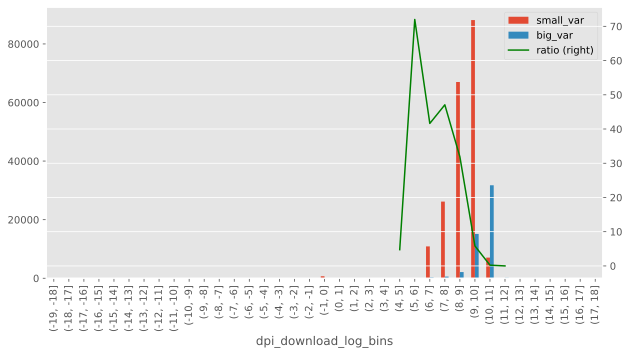

In [70]:
# temp = data_train.iloc[0:1000, :]
ratio_df = ratio_diagram(data_train, ['abon_id'], ['dpi_download_log_bins'], ['big_var'], ['small_var', 'big_var'])

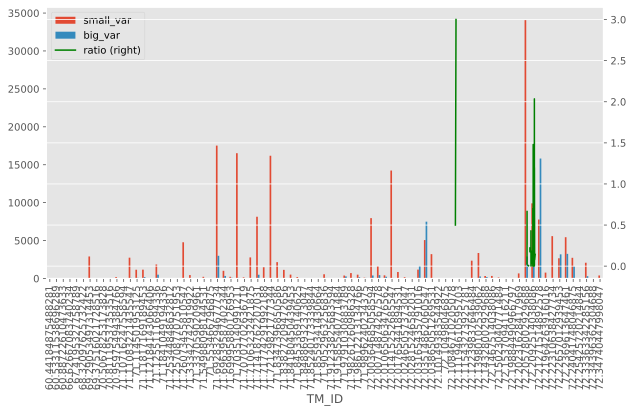

In [81]:
ratio_df = ratio_diagram(data_train, ['abon_id'], ['TM_ID'], ['big_var'], ['small_var', 'big_var'])

In [85]:
TM_ID_big_var = ratio_df[ratio_df['ratio'] > 1].index
TM_ID_big_var

Float64Index([60.53311538696289, 72.03165435791016, 72.03514862060547,
              72.21271514892578, 72.22657012939453],
             dtype='float64', name='TM_ID')

In [98]:
data_train['MV_ap_innet_out_v'].unique()

array([0.6714777 , 0.31014866, 0.26148185, ..., 0.07310907, 0.01980476,
       0.0326895 ], dtype=float32)

In [ ]:
ratio_df = ratio_diagram(data_train, ['abon_id'], ['MV_ap_innet_out_v'], ['big_var'], ['small_var', 'big_var'])

In [ ]:
fig = sns.scatterplot(x=data_train['var'], y=data_train['MV_ap_innet_out_v'], hue=data_train['big_var'])
fig.set(xlim = (-100,10000))

In [ ]:
fig = sns.scatterplot(x=data_train['var'], y=data_train['sum_paym_6_month'], hue=data_train['big_var'])
fig.set(xlim = (-100,10000))


In [ ]:
# X_train_full = data_train[big_slope_important_ft]
X_train_full = data_train.drop(traffic_cols + ['target', 'var', 'var_quant', 'slope_traff', 'z_score_slope', 'big_slope'], 
                               axis = 1)

y_train_full = data_train['var']


model = ltb.LGBMRegressor(objective ='regression',
                           random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)

print('RMSE train: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False)))
print('R^2 train: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred)))

In [ ]:
var_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
var_features[var_features['importance'] > 0].sort_values(by = 'importance', ascending=False)

In [ ]:
var_features = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
var_features[var_features['importance'] > 0].sort_values(by = 'importance', ascending=False)

In [ ]:
def find_outliers_z_score(col, threshhold = 3): 
    col_mean = col.mean()
    col_std = col.std(ddof = 0)
    c_zscore = (col - col_mean)/col_std
    indx_outliers = np.where (c_zscore.abs() > threshhold, True, False)
    return indx_outliers


In [ ]:
data_train.iloc[~find_outliers_z_score(data_train['non_accum_internet_vol_td_mnt3'])]['non_accum_internet_vol_td_mnt3'].\
                    hist(bins = 200)


In [ ]:
symlog = data_train['non_accum_internet_vol_td_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_train = data_train.assign(non_accum_internet_vol_td_mnt3_log = symlog)

symlog = data_test['non_accum_internet_vol_td_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_test = data_test.assign(non_accum_internet_vol_td_mnt3_log = symlog)

data_train = data_train.assign(non_accum_internet_vol_td_mnt3_log_bins = pd.cut(data_train['non_accum_internet_vol_td_mnt3_log'], 
                                                                                bins=range(-19, 19)))

data_test = data_test.assign(non_accum_internet_vol_td_mnt3_log_bins = pd.cut(data_test['non_accum_internet_vol_td_mnt3_log'], 
                                                                                bins=range(-19, 19)))

del symlog

In [ ]:
sns.scatterplot(x=data_train['non_accum_internet_vol_td_mnt3_log'],
                y=data_train['slope_traff'], hue=data_train['big_slope'])

In [ ]:
data_train.groupby(by = ['non_accum_internet_vol_td_mnt3_log_bins']).aggregate({'slope_traff': ['mean', 'median']}).plot()

In [ ]:
big_slope_by_non_accum = pd.pivot_table(data_train, 
                                        values='abon_id', 
                                        index='non_accum_internet_vol_td_mnt3_log_bins',
                                        columns='big_slope', aggfunc='count')
big_slope_by_non_accum.columns = ['small_slope', 'big_slope']
big_slope_by_non_accum = big_slope_by_non_accum.\
                            assign(small_to_big_ratio = big_slope_by_non_accum.small_slope/big_slope_by_non_accum.big_slope)


# big_slope_by_non_accum.sort_values(by = 'small_to_big_ratio', ascending = False)

ax1 = big_slope_by_non_accum.loc[:, ['small_slope', 'big_slope']].plot(kind = 'bar',
                                                                       figsize = (10,5),
                                                                       rot = 90,
                                                                       sharex = True)


ax1 = big_slope_by_non_accum['small_to_big_ratio'].plot(secondary_y=True,
                                                                colormap = 'ocean',
                                                                rot = 90, 
                                                                legend = True,
                                                                sharex = True);


In [ ]:
data_test[data_test['target'] >= 1]['traff_m1'].plot.hist(bins = 200)

In [153]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

34
887


In [154]:
data_train_num = data_train[num_col_list]
data_test_num = data_test[num_col_list]
# data_train_num_outliers_mask = mark_outliers(data_train_num)

In [ ]:
# # READING TRAIN AND TEST DATA NUMERICAL FEAUTURES ONLY WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train_num = pd.read_parquet(dir_path + 'model2_parquet/data_train_num.parquet.gzip')
data_test_num = pd.read_parquet(dir_path + 'model2_parquet/data_test_num.parquet.gzip')

In [ ]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [ ]:
data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
del data_train_num_outliers_mask

In [ ]:
data_train_num_corr = data_train_num.corr()

In [237]:
# # WRITING AND READING DATA_TRAIN_INFO DF TO PARQUET

# # data_train_num_info.to_parquet((dir_path + 'data_train_num_info.parquet.gzip'),compression='gzip')

data_train_num_info = pd.read_parquet(dir_path +'data_train_num_info.parquet.gzip')


In [238]:
# # WRITING AND READING DATA_TRAIN TARGET CORRELATION DF TO PARQUET

# # data_train_num_corr.to_parquet((dir_path + 'data_train_num_corr.parquet.gzip'),compression='gzip')

data_train_num_corr = pd.read_parquet(dir_path +'data_train_num_corr.parquet.gzip')


In [239]:
# ADDING TARGET CORR TO THE INFO DF
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)

In [178]:
del data_train_num_corr

In [258]:
# HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [ ]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.2%}",
                                                        'target': "{:.2f}"})
data_train_num_info_style

In [259]:
print('low target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() < 0.2].shape[0])


#PRINTING INFO DF FOR LOW TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() < 0.2].\
                            sort_values(by = 'target', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

low target corr features number:
801


In [256]:
print('high target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() >= 0.2].shape[0])

#PRINTING INFO DF FOR HIGH TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() >= 0.2].\
                            sort_values(by = '%nans', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

high target corr features number:
58


NameError: name 'highlight_perc' is not defined

In [240]:
#CHOOSING THE FEATURES WITH AT LEAST 0.2 CORRELATION COEFF WITH THE TARGET
# AND LESS THAN 60% OF MISSINGS

num_cols_to_use = data_train_num_info[(data_train_num_info['target'].abs() >= 0.2) &\
                                      (data_train_num_info['target'].abs() < 1) &\
                                      (data_train_num_info['%nans'] < 0.6)]['col'].to_list()
len(num_cols_to_use)

55

In [ ]:
sorted(num_cols_to_use)

In [241]:
# MERGING INFO DF WITH FEAUTURES DESCRIPTION AND CHOOSING MAX TARGET CORRELATED STAT METRIC FEAUTURES
data_descr = pd.read_csv((dir_path + 'data_descr.csv'), names=['feature', 'descr'])

data_train_num_info = pd.merge(data_train_num_info, data_descr, how='left', left_on='col', right_on='feature')
data_train_num_info.loc[data_train_num_info['descr'].isna(), 
                        'descr'] = data_train_num_info.loc[data_train_num_info['descr'].isna(), 'col']

data_train_num_info = data_train_num_info.assign(feature_clear = data_train_num_info['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

data_train_num_info['feature_clear'] = data_train_num_info.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

data_train_num_info = data_train_num_info.drop('feature', axis =1)

In [242]:
num_cols_to_use = list(data_train_num_info.loc[data_train_num_info['col'].isin(num_cols_to_use)].\
                                       groupby('feature_clear')['col'].max('target').values)

len(num_cols_to_use)

26

In [167]:
len(big_var_slope_features)

155

In [243]:
num_big_var_slope_features = [x for x in big_var_slope_features if x in num_col_list]
len(num_big_var_slope_features)

153

In [244]:
full_cols_to_use = list(set(num_cols_to_use + num_big_var_slope_features))


In [184]:
print(len(num_cols_to_use))
num_cols_to_use

168


['imei_mean_days_usage',
 'imei_max_price',
 'Internet',
 'device_height_mm',
 'data_3g_tar_vol_td_mnt3',
 'content_cnt_td_mnt3',
 'dpi_upload',
 'sum_paym_6_month',
 'DNZ_STD_days_closed_loan_year5',
 'voice_out_tar_dur_td_mnt3',
 'dpi_duration',
 'data_3g_tv_cnt_td_mnt3',
 'days_of_end_last_ppm',
 'DNZ_MEAN_days_closed_loan_year1',
 'cnt_bank_sms_category_forwardban',
 'MV_Traf_pstn_inc_v_Min',
 'num_act_days_td_mnt3',
 'MV_ot_4G_d',
 'DNZ_DAYS_from_last_year1',
 'bs_count_change_tp',
 'voice_mts_out_nwork_parttd_mnt3',
 'MV_dou_2G_d',
 'imei_mean_day_announced',
 'sms_out_cnt_td_mnt3',
 'cnt_bank_sms_category_awalbank',
 'MV_DOU_Neg_Bal',
 'data_3g_dou_td_mnt3',
 'MV_ot_Roam_d',
 'MV_ap_mn_out_v',
 'cnt_sms_category_bank',
 'cnt_sms_category_shop',
 'cnt_bank_sms_category_mtbbank',
 'MV_dou_out_s',
 'gprs_tar_vol_std_mnt3',
 'bs_of_recall_m1',
 'MV_ap_innet_out_v',
 'voice_out_cmpttrs_td_cnttd_mnt3',
 'non_accum_internet_vol_td_mnt3',
 'var_quant',
 'ks_num_part_td_mnt3',
 'all_clc_

In [185]:
data_test_num = data_test[num_col_list]

data_train_num_filtered = data_train_num[num_cols_to_use + ['target']]
data_test_num_filtered = data_test_num[num_cols_to_use + ['target']]


print(data_train_num_filtered.shape)
print(data_test_num_filtered.shape)

(250016, 169)
(243123, 169)


In [188]:
cat_col_list

['device_brand_samsung',
 'device_brand_nokia',
 'device_brand_lenovo',
 'device_brand_apple',
 'device_brand_huawei',
 'device_brand_lg',
 'device_brand_xiaomi',
 'device_brand_meizu',
 'device_brand_prestigio',
 'device_brand_sony',
 'device_brand_nan',
 'device_brand_other',
 'device_has_gprs',
 'device_has_wifi',
 'device_has_lte',
 'device_type_modem',
 'device_type_module',
 'device_type_phone',
 'device_type_smartphone',
 'device_type_tablet',
 'device_type_nan',
 'device_type_rus_other',
 'loc_is_obl_center',
 'serv_long_req_cnt',
 'serv_VF_bonus',
 'serv_smart_1m',
 'serv_year_nopay',
 'DNZ_COUNT_open_loan_year1',
 'MV_Migr_To',
 'active_ppm',
 'device_has_hardware_umts',
 'device_has_LTE_BAND_3',
 'big_slope']

In [189]:
#FILTERING CATEGORICAL COLUMNS INTO SEPARATE DF 

data_train_cat = data_train[cat_col_list]

data_test_cat = data_test[cat_col_list]

In [190]:
#FILTERING COLUMNS WITH BIGGEST TRAFFIC VAR INTO SEPARATE DF 

big_var_df_train = data_train_num_filtered[data_train_num_filtered['var_quant'] >= 8]
big_var_df_test = data_test_num_filtered[data_test_num_filtered['var_quant'] >= 8]

big_var_df_train = big_var_df_train.merge(data_train_cat, how  = 'left', left_index = True, right_index = True)
big_var_df_test = big_var_df_test.merge(data_test_cat, how  = 'left', left_index = True, right_index = True)


In [191]:
#FILTERING COLUMNS WITH BIGGEST TRAFFIC VAR INTO SEPARATE DF 

small_var_df_train = data_train_num_filtered[data_train_num_filtered['var_quant'] < 8]
small_var_df_test = data_test_num_filtered[data_test_num_filtered['var_quant'] < 8]

small_var_df_train = small_var_df_train.merge(data_train_cat, how  = 'left', left_index = True, right_index = True)
small_var_df_test = small_var_df_test.merge(data_test_cat, how  = 'left', left_index = True, right_index = True)

In [ ]:
# VISUALZING TARGET DIFFERENCE RATE FOR CATEGORICAL COLUMNS

target_by_cat_cols = pd.DataFrame(index=cat_col_list, 
                                  columns=['0_bv', '1_bv', '1_to_0_rate_bv','0_sv', '1_sv', '1_to_0_rate_sv'])

for col in cat_col_list:
    temp = big_var_df_train.pivot_table(columns=col,values='target', aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_bv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_bv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_bv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = np.nan
        
    temp = small_var_df_train.pivot_table(columns=col,values='target', aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_sv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_sv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_sv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = np.nan


ax1 = target_by_cat_cols.sort_index().loc[:, ['0_bv', '1_bv']].plot(kind = 'bar',
                                                                       figsize = (10,5),
                                                                       rot = 90,
                                                                       sharex = True)


ax1 = target_by_cat_cols.sort_index()['1_to_0_rate_bv'].plot(secondary_y=True,
                                                                colormap = 'ocean',
                                                                rot = 90, 
                                                                legend = True,
                                                                sharex = True);

ax1.set_title('big_var')
    
ax2 = target_by_cat_cols.sort_index().loc[:, ['0_sv', '1_sv']].plot(kind = 'bar',
                                                                    figsize = (10,5),
                                                                    rot = 90,
                                                                    sharex = True);

ax2 = target_by_cat_cols.sort_index()['1_to_0_rate_sv'].plot(secondary_y=True,
                                                             colormap = 'ocean',
                                                             rot = 90,
                                                             legend = True,
                                                             sharex = True);

ax2.set_title('small_var')

In [ ]:
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df_train.fillna(0)

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_train_big_var)
        sse.append(kmeans_batch.inertia_)
        
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [192]:
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df_train.fillna(0).astype('float32')
X_test_big_var = big_var_df_test.fillna(0).astype('float32')

kmeans_batch = MiniBatchKMeans(n_clusters=4, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch_train = kmeans_batch.fit_predict(X_train_big_var)

y_kmeans_batch_test = kmeans_batch.predict(X_test_big_var)


big_var_df_train = big_var_df_train.assign(cluster = y_kmeans_batch_train)

big_var_df_test = big_var_df_test.assign(cluster = y_kmeans_batch_test)

In [ ]:
# CHECKING MULTICOLLENEARITY IN DATA

def highlight_corr_06_plus(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_high = s >= 0.6
    return ['background-color: red' if v else '' for v in is_high]

collinear_cols_style = data_train_num_corr.loc[num_cols_to_use, num_cols_to_use].\
                                           style.apply(highlight_corr_06_plus).format("{:.2%}")


collinear_cols_style

In [ ]:
data_train_num_corr.loc[num_cols_to_use, num_cols_to_use]['dpi_duration'].sort_values()

In [ ]:
data_train_num_corr.loc[num_cols_to_use, num_cols_to_use]['MV_ARPU'].sort_values()

In [193]:
totals_for_pca = ['MV_ARPU', 'MV_ap_4G_d', 'MV_AP_total','all_clc_std_mnt3', 'clc_no_vas_roam_std_mnt3']
dpi_for_pca = ['dpi_duration', 'dpi_upload', 'dpi_download', 'dpi_events']

In [194]:
traffic_cols.sort()
traffic_cols_plus_target = ['traff_m5', 'traff_m3','traff_m2','traff_m1', 'target']
traffic_cols_plus_target.sort()

In [195]:
# DIMETIONALITY REDUCTION BY PCA FOR MULTICOLLINEAR COLUMNS

data_train_num_filtered = data_train_num_filtered.fillna(0)
data_test_num_filtered = data_test_num_filtered.fillna(0)


In [196]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")


In [197]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")

In [198]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(n_components = 1, random_state=3)
pca_test = PCA(n_components = 1, random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_test_std)



sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(n_components = 2, random_state=3)
pca_test = PCA(n_components = 2, random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_test_std)


del(X_train_std, X_test_std)

In [199]:
del data_test_num, data_train_num, data_train_cat, data_test_cat

In [255]:
num_cols_to_use

['slope_traff',
 'traff_m1',
 'traff_m2',
 'traff_m3',
 'traff_m5',
 'var_quant',
 'dpi_duration',
 'clc_no_vas_roam_std_mnt3',
 'dpi_events',
 'dpi_day_cnt',
 'content_cnt_mea_mnt3',
 'data_3g_tv_cnt_std_mnt1',
 'all_cnt_mea_mnt3',
 'all_clc_std_mnt3',
 'MV_ARPU',
 'dpi_download',
 'dpi_upload',
 'data_3g_tar_vol_std_mnt3',
 'non_accum_internet_vol_std_mnt3',
 'gprs_tar_vol_std_mnt3',
 'MV_ap_4G_d',
 'MV_ap_innet_out_v',
 'MV_AP_total',
 'MV_Traf_2G_d_Mb',
 'MV_Traf_3G_d_Mb',
 'MV_Traf_4G_d_Mb']

In [261]:
# PREPARING DATA FOR MODELS

# data_train_model = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip').fillna(0)
# temp_train = data_train_num_filtered.copy()

data_train_num_filtered = temp_train[num_cols_to_use +['target']]

data_train_model = data_train_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
data_train_model = data_train_model.drop(dpi_for_pca, axis=1)
data_train_model = data_train_model.assign(pca1=X_train_pca_totals[:, 0],
                                           pca2=X_train_pca_dpi[:, 0],
                                           pca3=X_train_pca_dpi[:, 1])

data_train_model_varQ90 = data_train_model[data_train_model['var_quant'] >= 8]
data_train_model_varQ90 = data_train_model_varQ90.merge(big_var_df_train['cluster'], how='left',
                                                       left_index = True, right_index = True)

data_train_model_full = data_train_model
data_train_model = data_train_model[~data_train_model['var_quant'].isin([8,9])]

data_train_model_varQ90 = data_train_model_varQ90.fillna(0)

In [262]:
# data_test_model = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip').fillna(0)
# temp_test = data_test_num_filtered.copy()
data_test_num_filtered = temp_test[num_cols_to_use +['target']]

data_test_model = data_test_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
data_test_model = data_test_model.drop(dpi_for_pca, axis=1)
data_test_model = data_test_model.assign(pca1=X_test_pca_totals[:, 0],
                                         pca2=X_test_pca_dpi[:, 0],
                                         pca3=X_test_pca_dpi[:, 1])

data_test_model_varQ90 = data_test_model[data_test_model['var_quant'] >= 8]
data_test_model_varQ90 = data_test_model_varQ90.merge(big_var_df_train['cluster'], how='left',
                                                      left_index = True, right_index = True)

data_test_model_full = data_test_model
data_test_model = data_test_model[~data_test_model['var_quant'].isin([8,9])]

data_test_model_varQ90 = data_test_model_varQ90.fillna(0)

In [ ]:
data_train_model.columns

In [220]:
def df_normalization(df, cols_to_exclude = []):
    
    
    cols_to_use = list(df.columns)
   
    for col in cols_to_exclude:
        cols_to_use.remove(col)
        
    df_norm = df.copy()
    
    for column in cols_to_use: 
        df_norm[column] = (df_norm[column] - df_norm[column].min()) /(df_norm[column].max() - df_norm[column].min()) 

    return df_norm

In [251]:
X, y = data_train_model.loc[:, data_train_model.columns != 'target'], data_train_model.target

# X = df_normalization(X, ['var_quant'])

X = df_normalization(X, [])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

X_full, y_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target'], data_test_model_full.target

X_full = df_normalization(X_full, ['var_quant'])

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.30, random_state = 17)

X_varQ90 = data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target']
y_varQ90 = data_train_model_varQ90.target

X_varQ90 = df_normalization(X_varQ90, ['var_quant'])

X_train_varQ90, X_test_varQ90, y_train_varQ90, y_test_varQ90 = train_test_split(X_varQ90, y_varQ90, 
                                                                                test_size=0.30, random_state = 17)


In [252]:
X_test_test, y_test_test = data_test_model.loc[:, data_test_model.columns != 'target'], data_test_model.target

# X_test_test = df_normalization(X_test_test, ['var_quant'])
X_test_test = df_normalization(X_test_test, [])

X_test_test_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target']
X_test_test_full = df_normalization(X_test_test_full, ['var_quant'])
y_test_test_full = data_test_model_full.target

X_test_test_varQ90 = data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target']
X_test_test_varQ90 = df_normalization(X_test_test_varQ90, ['var_quant'])
y_test__test_varQ90 = data_test_model_varQ90.target


### MODELS

In [ ]:
X_train_full = X_train_full.drop('var_quant', axis = 1)
X_test_full = X_test_full.drop('var_quant', axis = 1)
X_test_test_full = X_test_test_full.drop('var_quant', axis = 1)

In [253]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



RMSE train: 7.976912, test: 8.592163, test_test: 8.166356
R^2 train: 0.530978, test: 0.452321, test_test:0.507487


In [209]:
n_folds = 5

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.05, 0.15, 0.20],
              'n_estimators': [100, 200, 300, 400],
              'reg_alpha':[0.05, 0.7, 0.8]}


lgbm = LGBMRegressor(silent=True, random_state= 3)

grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
res = grid_search.fit(X_train_full, y_train_full)


res


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=3), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.15, 0.2],
                         'n_estimators': [100, 200, 300, 400],
                         'reg_alpha': [0.05, 0.7, 0.8]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=True)

In [211]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

Best score: -8.593911959919021 

Best parameters set:
	learning_rate:  0.05
	n_estimators:  200
	reg_alpha:  0.7


In [212]:
grid_search.cv_results_.get('mean_test_score')

array([-8.59943981, -8.60492098, -8.60274466, -8.59996368, -8.59391196,
       -8.59640193, -8.60467089, -8.59830939, -8.59607914, -8.60930284,
       -8.60219828, -8.60264911, -8.65982663, -8.65547941, -8.65658734,
       -8.69754348, -8.68914235, -8.69969081, -8.72672067, -8.72101464,
       -8.7246924 , -8.7530199 , -8.74423118, -8.75467936, -8.69920713,
       -8.70752549, -8.70819707, -8.75226992, -8.76430121, -8.76494779,
       -8.79543949, -8.80888212, -8.81308064, -8.83065351, -8.84461699,
       -8.85115937])

In [215]:
grid_search.cv_results_.get('params')[35]

{'learning_rate': 0.2, 'n_estimators': 400, 'reg_alpha': 0.8}

In [254]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0,
                          learning_rate = 0.05,
                          n_estimators = 200, 
                          reg_alpha = 0.7)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



RMSE train: 7.977181, test: 8.568982, test_test: 8.159230
R^2 train: 0.530946, test: 0.455272, test_test:0.508347


In [ ]:
RMSE train: 7.706064, test: 8.513880, test_test: 7.957025
R^2 train: 0.562287, test: 0.462255, test_test:0.532413